In [1]:
# Jason Hemedinger
# Argonne National Laboratory

In [20]:
import pyart, boto3, tempfile, os, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from botocore.handlers import disable_signing
from tint import Cell_tracks
from tint import animate as tint_animate
from tint.visualization import embed_mp4_as_gif
from glob import glob
from datetime import datetime
from pylab import *

In [3]:
def get_current_scan(station, key_index):
    '''
    Function will pull the latest radar scan from any radar site using 
    Amazon S3.
    ----------
    station = Four letter NEXRAD identifier, must be entered using quote marks
              Example: 'KEPZ'
            
    key_index = Number of keys you want pulled. 
                If a positive number then the number of keys pulled will start from the first key of the day.
                If a negative number then the number of keys pulled will count backwards from most recent key.
                Example: 15 would pull the first 15 keys for the day, while -15 would
                pull the 15 most recent keys
    '''
    #creating a bucket and a client to be able to pull data from AWS and setting 
    #it as unsigned
    bucket = 'noaa-nexrad-level2'
    s3 = boto3.resource('s3')
    s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
    
    #connects the bucket create above with radar data
    aws_radar = s3.Bucket(bucket)
    
    #setting the date and time to current.
    #this will allow for allow the current date's radar scands to be pulled
    desired_datetime = datetime.utcnow()
    target_string = datetime.strftime(desired_datetime, '%Y/%m/%d/'+station)
    
    for obj in aws_radar.objects.filter(Prefix= target_string):
        '{0}:{1}'.format(aws_radar.name, obj.key)
    my_list_of_keys = [this_object.key for this_object in aws_radar.objects.filter(Prefix= target_string)]
    keys = my_list_of_keys[key_index:]
    print(my_list_of_keys[key_index:])
    
    return aws_radar, keys

In [4]:
#creating a new directory for each day of an event
path = '/home/jhemedinger/suli_projects/chicago-nowcast/events'
date = datetime.utcnow().strftime('%Y_%m_%d')
date = str(date)
out_dir_path = path+'/'+date
out_dir = os.makedirs(out_dir_path, exist_ok=True)

#within the newly created directory, creating a directory for each event
event_date = datetime.utcnow().strftime('%Y%m%d-%H')
event_date = str(event_date)
out_path_dir = path+'/'+date+'/'+event_date+'Z'
out_path = os.makedirs(out_path_dir, exist_ok=True)

In [5]:
#setting the radar site and which keys to pull.
aws_radar, keys = get_current_scan('KLOT', key_index=-10)

['2018/06/26/KLOT/KLOT20180626_130047_V06', '2018/06/26/KLOT/KLOT20180626_130547_V06', '2018/06/26/KLOT/KLOT20180626_131048_V06', '2018/06/26/KLOT/KLOT20180626_131549_V06', '2018/06/26/KLOT/KLOT20180626_132047_V06', '2018/06/26/KLOT/KLOT20180626_132548_V06', '2018/06/26/KLOT/KLOT20180626_133047_V06', '2018/06/26/KLOT/KLOT20180626_133547_V06', '2018/06/26/KLOT/KLOT20180626_134047_V06', '2018/06/26/KLOT/KLOT20180626_134548_V06']


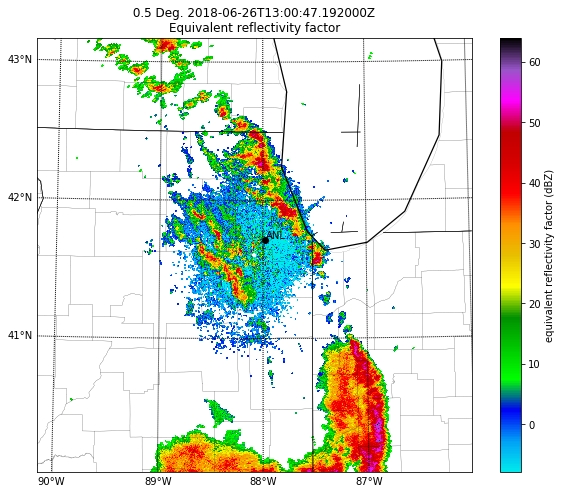

In [6]:
def animate(nframe):
    plt.clf()
    localfile = tempfile.NamedTemporaryFile()
    aws_radar.download_file(keys[nframe], localfile.name)
    # Only pulling two scans for the sake of time and memory.
    radar = pyart.io.read(localfile.name)
    display = pyart.graph.RadarMapDisplay(radar)
    # Delete radar after use to save memory.
    del radar
    display.plot_ppi_map('reflectivity', resolution='l', 
                         vmin=-8, vmax=64, mask_outside=False,
                         sweep=0, width=350000, height=350000)
    display.basemap.drawcounties()
    display.plot_point(-87.981810, 41.713969, label_text='ANL', color='k')
fig = plt.figure(figsize=(10, 8))
anim_klot = animation.FuncAnimation(fig, animate,
                                    frames=len(keys))
anim_klot.save(out_path_dir+'/reflectivity_animation.gif', 
               writer='imagemagick', fps=2)
plt.show()
plt.close()

In [7]:
#turing the data into grid data and saving it to a folder
def get_grid(aws_radar, key):
    localfile = tempfile.NamedTemporaryFile()
    aws_radar.download_file(key, localfile.name)
    radar = pyart.io.read(localfile.name)
    grid = pyart.map.grid_from_radars(
            radar, grid_shape=(31, 401, 401),
            grid_limits=((0, 15000), (-200000, 200000), (-200000, 200000)),
            fields=['reflectivity'], gridding_algo='map_gates_to_grid',
            h_factor=0., nb=0.6, bsp=1., min_radius=200.)
    return grid

for num,key in enumerate(keys):
    print('saving grid', num)
    grid = get_grid(aws_radar, key)
    name = os.path.join(out_path_dir, 'grid_' + str(num).zfill(3) + '.nc')
    pyart.io.write_grid(name, grid)
    del grid

saving grid 0
saving grid 1
saving grid 2
saving grid 3
saving grid 4
saving grid 5
saving grid 6
saving grid 7
saving grid 8
saving grid 9


In [8]:
#files_2 = [os.path.join(out_dir, fn) for fn in os.listdir(out_dir)]
#out_path_dir = '/home/jhemedinger/suli_projects/chicago-nowcast/events/2018_06_19/20180619-21Z'
files = glob(out_path_dir + '/grid_*')
files.sort()

In [9]:
grid_gen = (pyart.io.read_grid(f) for f in files)
#grid_list = [pyart.io.read_grid(f) for f in files]

In [10]:
tracks_obj = Cell_tracks()
tracks_obj.get_tracks(grid_gen)

Writing tracks for scan 0
Writing tracks for scan 1
Writing tracks for scan 2
Writing tracks for scan 3
Writing tracks for scan 4
Writing tracks for scan 5
Writing tracks for scan 6
Writing tracks for scan 7
Writing tracks for scan 8
Writing tracks for scan 9


time elapsed 0.1 minutes


In [11]:
tracks_obj.tracks

time   grid_x   grid_y      lon      lat    area  \
scan uid                                                                   
0    0   2018-06-26 13:00:47  233.782   39.443 -87.6844  40.1558  8071.0   
     1   2018-06-26 13:00:47  270.316   43.684 -87.2603  40.1985    19.0   
     2   2018-06-26 13:00:47  183.295  179.107 -88.2883  41.4154   122.0   
     3   2018-06-26 13:00:47  188.219  187.562 -88.2285  41.4964    32.0   
     4   2018-06-26 13:00:47  172.111  186.556 -88.4206  41.4870     9.0   
     5   2018-06-26 13:00:47  194.138  196.931 -88.1566  41.5774    29.0   
     6   2018-06-26 13:00:47  252.103  197.310 -87.4593  41.5758    87.0   
     7   2018-06-26 13:00:47  165.400  199.780 -88.5054  41.6037    50.0   
     8   2018-06-26 13:00:47  183.583  203.083 -88.2770  41.6313    12.0   
     9   2018-06-26 13:00:47  158.657  206.400 -88.5780  41.6573    35.0   
     10  2018-06-26 13:00:47  190.250  205.500 -88.2048  41.6583    20.0   
     11  2018-06-26 13:00:47  247.161  206.613 -87.5186  41.6660    31.0   
     12  2018-06-26 13:00:47  172.119  218.169 -88.4220  41.7658    59.0   
     13  2018-06-26 13:00:47  234.655  218.207 -87.6624  41.7656    29.0   
     14  2018-06-26 13:00:47  225.325  238.354 -87.7822  41.9458   246.0   
     15  2018-06-26 13:00:47  155.897  233.641 -88.6162  41.9090    39.0   
     16  2018-06-26 13:00:47  204.615  246.231 -88.0239  42.0181    13.0   
     17  2018-06-26 13:00:47  214.118  249.294 -87.9149  42.0450    17.0   
     18  2018-06-26 13:00:47  210.710  260.161 -87.9510  42.1440    31.0   
     19  2018-06-26 13:00:47  220.750  260.333 -87.8297  42.1438    12.0   
     20  2018-06-26 13:00:47  207.365  275.224 -87.9994  42.2789   170.0   
     21  2018-06-26 13:00:47  194.733  280.900 -88.1453  42.3329    30.0   
     22  2018-06-26 13:00:47  203.847  294.271 -88.0357  42.4498   118.0   
     23  2018-06-26 13:00:47  190.029  305.571 -88.2065  42.5577    35.0   
     24  2018-06-26 13:00:47  175.586  315.345 -88.3778  42.6383    29.0   
     25  2018-06-26 13:00:47  124.250  335.417 -89.0161  42.8148    36.0   
     26  2018-06-26 13:00:47  106.500  349.864 -89.2393  42.9477    22.0   
     27  2018-06-26 13:00:47  129.713  369.931 -88.9470  43.1301   101.0   
1    28  2018-06-26 13:05:47  175.943   18.773 -88.3661  39.9763  3235.0   
     0   2018-06-26 13:05:47  282.571   56.119 -87.1057  40.3052  4368.0   
...                      ...      ...      ...      ...      ...     ...   
9    87  2018-06-26 13:45:48  343.400   86.320 -86.3915  40.5667    25.0   
     94  2018-06-26 13:45:48  307.375  125.625 -86.8107  40.9319     8.0   
     76  2018-06-26 13:45:48  312.222  129.833 -86.7505  40.9672    18.0   
     77  2018-06-26 13:45:48  295.875  187.125 -86.9320  41.4818     8.0   
     78  2018-06-26 13:45:48  294.821  194.393 -86.9429  41.5448    28.0   
     80  2018-06-26 13:45:48  216.556  200.861 -87.8800  41.6133    36.0   
     79  2018-06-26 13:45:48  195.500  202.000 -88.1326  41.6224     8.0   
     6   2018-06-26 13:45:48  276.023  214.651 -87.1685  41.7357    43.0   
     63  2018-06-26 13:45:48  224.704  224.330 -87.7828  41.8199   115.0   
     95  2018-06-26 13:45:48  211.778  222.000 -87.9397  41.8022     9.0   
     96  2018-06-26 13:45:48  265.750  224.000 -87.2880  41.8175     8.0   
     5   2018-06-26 13:45:48  205.321  229.179 -88.0241  41.8652    28.0   
     31  2018-06-26 13:45:48  225.562  233.688 -87.7702  41.9098    32.0   
     97  2018-06-26 13:45:48  200.769  234.615 -88.0724  41.9192    13.0   
     43  2018-06-26 13:45:48  205.163  243.184 -88.0239  41.9911    98.0   
     82  2018-06-26 13:45:48  246.778  249.764 -87.5152  42.0527   144.0   
     12  2018-06-26 13:45:48  177.925  256.008 -88.3511  42.1078   241.0   
     98  2018-06-26 13:45:48  158.750  250.375 -88.5810  42.0530     8.0   
     99  2018-06-26 13:45:48  236.333  263.000 -87.6476  42.1702     9.0   
     14  2018-06-26 13:45:48  228.874  269.748 -87.7322  42.2334   111.0

In [12]:
if os.path.exists(out_path_dir + '/test_animation.mp4'):
    print(out_path_dir + '/test_animation.mp4'
          + ' already exists, removing file')
    os.remove(out_path_dir + '/test_animation.mp4')

In [13]:
grid_gen = (pyart.io.read_grid(f) for f in files)
tint_animate(tracks_obj, grid_gen, os.path.join(out_path_dir, 'test_animation'))

foobar
Animating 10 frames
Frame: 0
reflectivity 3
-8 64
Frame: 1
reflectivity 3
-8 64
Frame: 2
reflectivity 3
-8 64
Frame: 3
reflectivity 3
-8 64
Frame: 4
reflectivity 3
-8 64
Frame: 5
reflectivity 3
-8 64
Frame: 6
reflectivity 3
-8 64
Frame: 7
reflectivity 3
-8 64
Frame: 8
reflectivity 3
-8 64
Frame: 9
reflectivity 3
-8 64


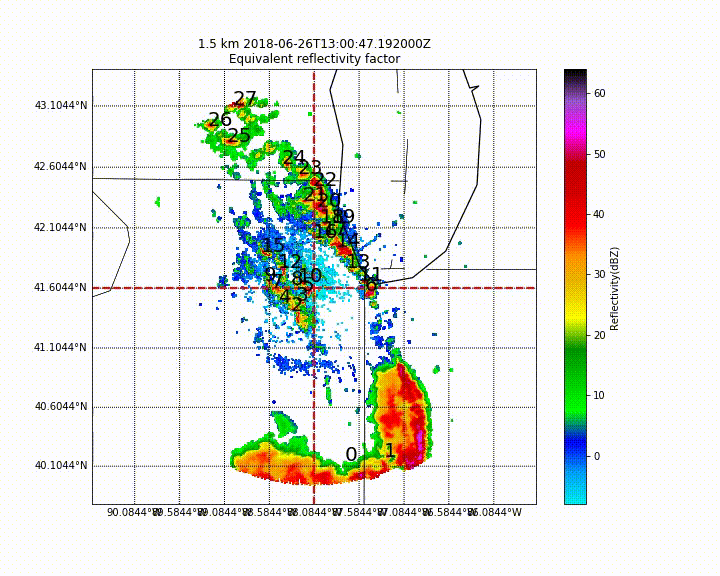

In [14]:
embed_mp4_as_gif(out_path_dir + '/test_animation.mp4')

In [67]:
df = pd.DataFrame(tracks_obj.tracks)
idx = pd.IndexSlice

#arr = np.arange(0,101,1)

#for i in arr:
#    df_row = df.loc[idx[:, str(i)],:]
#    df_row['time'] = pd.to_datetime(df_row['time'])
#    print(df_row)
#    del df_row

for uid in cells:
    print(uid)

('0',                         time   grid_x  grid_y      lon      lat    area  \
scan uid                                                                  
0    0   2018-06-26 13:00:47  233.782  39.443 -87.6844  40.1558  8071.0   
1    0   2018-06-26 13:05:47  282.571  56.119 -87.1057  40.3052  4368.0   
2    0   2018-06-26 13:10:48  286.660  55.424 -87.0587  40.2958  3984.0   
3    0   2018-06-26 13:15:49  290.595  55.898 -87.0114  40.3044  4257.0   
4    0   2018-06-26 13:20:47  294.085  47.249 -86.9774  40.2231  3505.0   
5    0   2018-06-26 13:25:48  298.774  56.111 -86.9171  40.3034  4039.0   
6    0   2018-06-26 13:30:47  302.373  55.307 -86.8819  40.2941  3851.0   

              vol        max  max_alt  isolated  
scan uid                                         
0    0    30747.5  58.924301     13.5     False  
1    0    18829.0  59.881680     13.5     False  
2    0    16270.0  58.504211     10.0     False  
3    0    17423.5  59.856903     10.5     False  
4    0    14959.5 

6    70   38.000492      3.5     False  )
('71',                         time   grid_x   grid_y      lon      lat  area   vol  \
scan uid                                                                       
6    71  2018-06-26 13:30:47  253.875  204.125 -87.4346  41.6386   8.0  13.0   

                max  max_alt  isolated  
scan uid                                
6    71   44.720413      3.0     False  )
('72',                         time   grid_x   grid_y      lon      lat  area   vol  \
scan uid                                                                       
6    72  2018-06-26 13:30:47  215.667  260.667 -87.8904  42.1529   9.0  15.5   

                max  max_alt  isolated  
scan uid                                
6    72   39.939831      3.0     False  )
('73',                         time  grid_x  grid_y     lon      lat  area   vol  \
scan uid                                                                    
7    73  2018-06-26 13:35:47   255.9     0.4 -87.429 

In [68]:
tracks_obj.tracks.groupby(level='uid').size().sort_values(ascending=False)[:]

uid
5     10
12    10
6     10
20    10
14    10
23    10
31     9
9      9
13     8
36     8
26     8
28     8
11     8
43     8
46     8
45     8
44     8
15     7
30     7
0      7
38     6
25     6
4      5
50     5
27     5
63     5
35     5
24     4
16     4
51     4
      ..
72     1
97     1
96     1
95     1
94     1
93     1
92     1
88     1
86     1
85     1
83     1
81     1
74     1
73     1
71     1
39     1
70     1
69     1
68     1
62     1
61     1
60     1
59     1
56     1
54     1
98     1
52     1
48     1
41     1
53     1
Length: 101, dtype: int64

['2018-06-26T13:00:47.000000000' '2018-06-26T13:05:47.000000000'
 '2018-06-26T13:10:48.000000000' '2018-06-26T13:15:49.000000000'
 '2018-06-26T13:20:47.000000000' '2018-06-26T13:25:48.000000000'
 '2018-06-26T13:30:47.000000000' '2018-06-26T13:35:47.000000000'
 '2018-06-26T13:40:47.000000000' '2018-06-26T13:45:48.000000000']


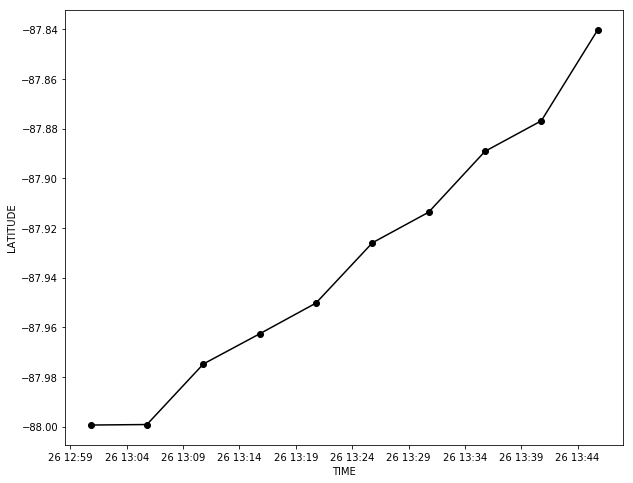

In [69]:
df_20 = pd.DataFrame(tracks_obj.tracks.xs('20', level='uid'))
#df_41 = df_41.drop('time', axis=1)
#print(df_123)
lons, lats = np.array(df_20['lon']), np.array(df_20['lat'])
#time = pd.to_numeric(df_20['time'])
#time = pd.to_datetime(time)
time = np.array(pd.to_datetime(df_20['time']))
print(time)
fig = plt.figure(figsize=(10,8))
plt.plot(time, lons, color='k', marker='o')
#plt.ylim(plt.ylim()[::-1])
plt.xlabel('TIME')
plt.ylabel('LATITUDE')
#for i, lpoint in enumerate(df_row['time']):
#plt.annotate(' {0:d} h'.format(lpoint.hour), (lons[i], lats[i]), 
#xytext=(15,0), textcoords='offset points', 
#fontsize=12, color='darkblue')
plt.show()
plt.close()

In [70]:
ts = (time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')

/home/jhemedinger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  """Entry point for launching an IPython kernel.


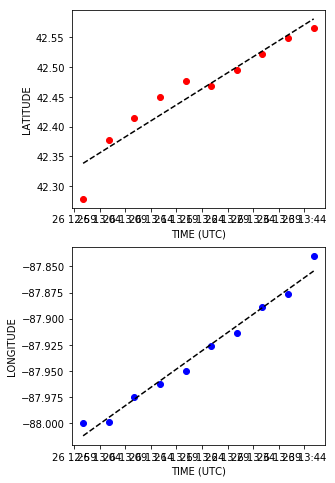

In [71]:
x = ts
y = lats
w = lons

fit_lat = polyfit(x,y,1)
fit_lon = polyfit(x,w,1)
fit_fn_lon = poly1d(fit_lon)
fit_fn_lat = poly1d(fit_lat)

fig = plt.figure(1 ,figsize=(10,8))

ax = plt.subplot(221)
plt.plot(time, y, 'ro', time, fit_fn_lat(x), '--k')
#plt.plot(lons, lats, color='y', marker='o')
#plt.plot(time, fit_fn_lat(x), '--k')
#plt.plot(time, lats, 'ro')
plt.xlabel('TIME (UTC)')
plt.ylabel('LATITUDE')

ax = plt.subplot(223)
plt.plot(time, w, 'bo', time, fit_fn_lon(x), '--k')
plt.xlabel('TIME (UTC)')
plt.ylabel('LONGITUDE')

plt.show()

In [72]:
my_new_time = time[-1] + np.timedelta64(10, 'm')

In [73]:
nts = (my_new_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
my_new_lat = fit_fn_lat(nts)
my_new_lon = fit_fn_lon(nts)

/home/jhemedinger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  """Entry point for launching an IPython kernel.


In [74]:
print(my_new_lat)
print(my_new_lon)

42.6348691513
-87.8194305558


In [75]:
cells = tracks_obj.tracks.groupby(level='uid')

In [76]:
for uid in cells:
    print(uid)

('0',                         time   grid_x  grid_y      lon      lat    area  \
scan uid                                                                  
0    0   2018-06-26 13:00:47  233.782  39.443 -87.6844  40.1558  8071.0   
1    0   2018-06-26 13:05:47  282.571  56.119 -87.1057  40.3052  4368.0   
2    0   2018-06-26 13:10:48  286.660  55.424 -87.0587  40.2958  3984.0   
3    0   2018-06-26 13:15:49  290.595  55.898 -87.0114  40.3044  4257.0   
4    0   2018-06-26 13:20:47  294.085  47.249 -86.9774  40.2231  3505.0   
5    0   2018-06-26 13:25:48  298.774  56.111 -86.9171  40.3034  4039.0   
6    0   2018-06-26 13:30:47  302.373  55.307 -86.8819  40.2941  3851.0   

              vol        max  max_alt  isolated  
scan uid                                         
0    0    30747.5  58.924301     13.5     False  
1    0    18829.0  59.881680     13.5     False  
2    0    16270.0  58.504211     10.0     False  
3    0    17423.5  59.856903     10.5     False  
4    0    14959.5 

6    68   33.626217      3.0     False  )
('69',                         time   grid_x  grid_y      lon    lat  area    vol  \
scan uid                                                                     
6    69  2018-06-26 13:30:47  264.076  42.894 -87.3311  40.19  66.0  148.5   

                max  max_alt  isolated  
scan uid                                
6    69   37.138271      4.5     False  )
('7',                         time   grid_x   grid_y      lon      lat  area   vol  \
scan uid                                                                       
0    7   2018-06-26 13:00:47  165.400  199.780 -88.5054  41.6037  50.0  89.5   
1    7   2018-06-26 13:05:47  169.409  202.364 -88.4574  41.6218  22.0  25.5   

                max  max_alt  isolated  
scan uid                                
0    7    43.590008      4.5     False  
1    7    42.500000      4.0     False  )
('70',                         time   grid_x   grid_y      lon      lat  area   vol  \
scan uid     

In [77]:
tracks_obj.tracks.groupby(level='uid').size().sort_values(ascending=False)[:]

uid
5     10
12    10
6     10
20    10
14    10
23    10
31     9
9      9
13     8
36     8
26     8
28     8
11     8
43     8
46     8
45     8
44     8
15     7
30     7
0      7
38     6
25     6
4      5
50     5
27     5
63     5
35     5
24     4
16     4
51     4
      ..
72     1
97     1
96     1
95     1
94     1
93     1
92     1
88     1
86     1
85     1
83     1
81     1
74     1
73     1
71     1
39     1
70     1
69     1
68     1
62     1
61     1
60     1
59     1
56     1
54     1
98     1
52     1
48     1
41     1
53     1
Length: 101, dtype: int64

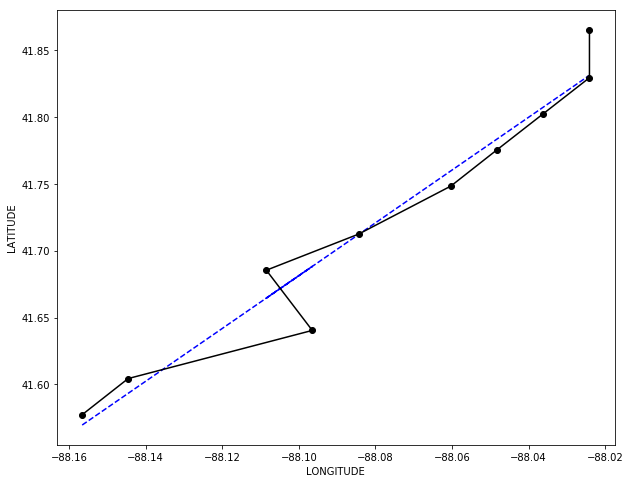

In [98]:
df_5 = pd.DataFrame(tracks_obj.tracks.xs('5', level='uid'))
lons, lats = np.array(df_5['lon']), np.array(df_5['lat'])
#time = pd.to_numeric(df_20['time'])
#time = pd.to_datetime(time)
time = np.array(pd.to_datetime(df_5['time']))

fit = polyfit(lons,lats,1)
fit_fn = poly1d(fit)

fig = plt.figure(figsize=(10,8))
plt.plot(lons, fit_fn(lons), '--b')
plt.plot(lons, lats, color='k', marker='o')
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.show()
plt.close()

In [99]:
ts = (time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')

/home/jhemedinger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  """Entry point for launching an IPython kernel.


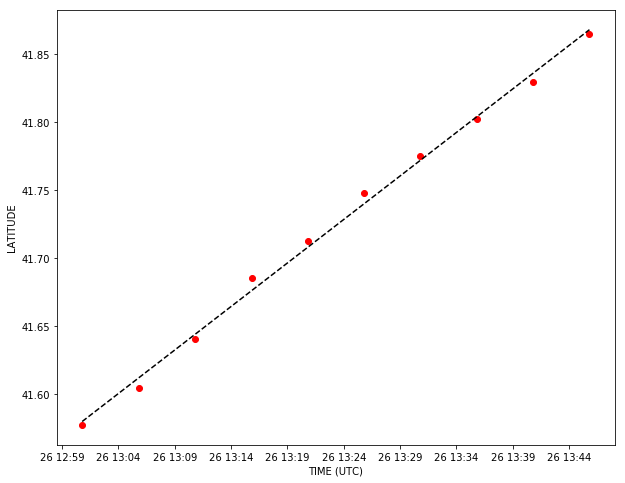

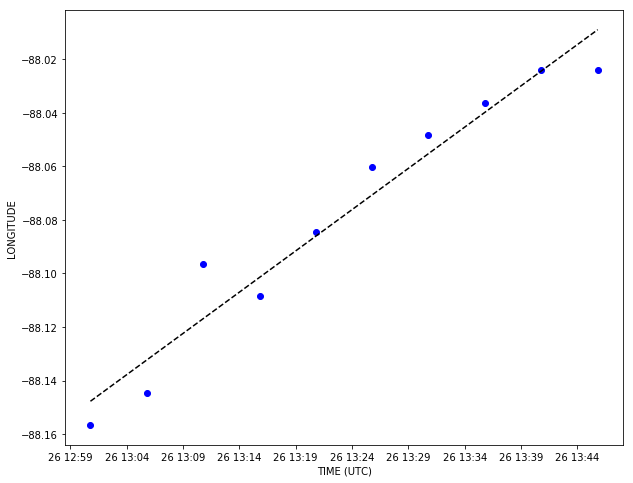

In [101]:
x = ts
y = lats
w = lons

fit_lat = polyfit(x,y,1)
fit_lon = polyfit(x,w,1)
fit_fn_lon = poly1d(fit_lon)
fit_fn_lat = poly1d(fit_lat)

fig = plt.figure(figsize=(10,8))
plt.plot(time, y, 'ro', time, fit_fn_lat(x), '--k')
plt.xlabel('TIME (UTC)')
plt.ylabel('LATITUDE')
plt.show()
plt.close()

fig = plt.figure(figsize=(10,8))
plt.plot(time, w, 'bo', time, fit_fn_lon(x), '--k')
plt.xlabel('TIME (UTC)')
plt.ylabel('LONGITUDE')
plt.show()
plt.close()

In [95]:
arr = np.arange(10,110,10)
for i in arr:
    my_new_time = time[-1] + np.timedelta64(str(i), 'm')
    nts = ((my_new_time - np.datetime64('1970-01-01T00:00:00Z')) 
           / np.timedelta64(1, 's'))
    my_new_lat = fit_fn_lat(nts)
    my_new_lon = fit_fn_lon(nts)
    print(my_new_time)
    print('%8.4f' %my_new_lat)
    print('%8.4f' %my_new_lon)
    print('--------')

2018-06-26T13:55:48.000000000
 41.9321
-87.9782
--------
2018-06-26T14:05:48.000000000
 41.9961
-87.9474
--------
2018-06-26T14:15:48.000000000
 42.0601
-87.9166
--------
2018-06-26T14:25:48.000000000
 42.1241
-87.8857
--------
2018-06-26T14:35:48.000000000
 42.1881
-87.8549
--------
2018-06-26T14:45:48.000000000
 42.2521
-87.8241
--------
2018-06-26T14:55:48.000000000
 42.3161
-87.7933
--------
2018-06-26T15:05:48.000000000
 42.3801
-87.7625
--------
2018-06-26T15:15:48.000000000
 42.4441
-87.7317
--------
2018-06-26T15:25:48.000000000
 42.5081
-87.7008
--------


/home/jhemedinger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  after removing the cwd from sys.path.
/home/jhemedinger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  after removing the cwd from sys.path.
/home/jhemedinger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  after removing the cwd from sys.path.
/home/jhemedinger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  after removing the cwd from sys.path.
/home/jhemedinger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: Depreca

ValueError: x and y must not be None

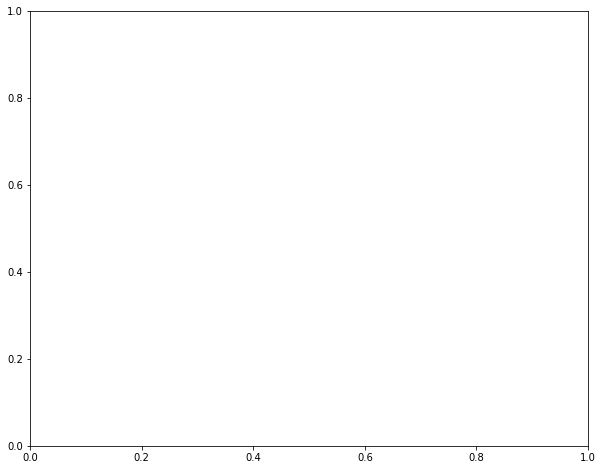

In [93]:
fig = plt.figure(figsize=(10,8))
plt.plot(lons, lats, color='r', marker='*')
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.show()
plt.close()